In [1]:
include("/Users/quaidzahid/Documents/Research Professor/Mikhail Erementchouk/HN_V2/scripts/intro.jl")

using Graphs
using SimpleWeightedGraphs
using Dice 
using PrettyTables
using LinearAlgebra

using GraphPlot
using Plots
using HNProcess
using DataRefine
using PartitioningData
using Random

LoadError: SystemError: opening file "\\Users\\quaidzahid\\Documents\\Research Professor\\Mikhail Erementchouk\\HN_V2\\scripts\\intro.jl": No such file or directory

In [7]:
# I want to do the following:
# Obtain stimulus by taking random image
# Acquire exactly half of the pixels and set them
# randomly fill the rest
function get_random_stimuli(params, r)
    stim_temp = shuffle(params["images"])[1]
    stim_selects = shuffle(1:length(stim_temp))[1:r]
    stimuli = []
    for i in stim_selects
        #println(i)
        s = (i%size(stim_temp,1), round(Int,floor(i/size(stim_temp,1))+1), stim_temp[i]) #(row, col, state)
        if s[1] == 0 
           # println(s)
            s = (s[1] + size(stim_temp,1), s[2] - 1, s[3])
           # println(s)
        end
        #println(s)
        #pos = (s[2]-1) * size(parameters["images"][1],1) + s[1]
        #println(pos)
        push!(stimuli, s)
        #println("\n\n\n\n")
    end
    #@show stimuli
    return stimuli
end

get_random_stimuli (generic function with 1 method)

In [8]:
# I want to find all images that have that stimuli
# This will show all possible solutions to check that we have everything
# Take stim
# Take image
# Check stim in image, if good, keep, if not remove
function show_available_solutions(params, m = true)
    ims = copy(params["images"])
    #@show parameters["images"]
    for i in params["initial_stimuli"]
        pos = (i[2]-1) * size(params["images"][1],1) + i[1]
        #println(i)
        #println(pos)
        #println(length(ims))
        ims = filter(k -> k[pos] == i[3], ims)
        #println(length(ims))
        length(ims) <= 2 && break
        #println("\n\n")
    end

    if m
        for i in ims
            pretty_table(i)
        end
    end
    return ims
end

show_available_solutions (generic function with 2 methods)

In [9]:
sim_time = 8
steps = 6000
im_all = orthogonal_image_generator(64)
println(length(im_all))
selected::Vector{Matrix{Int64}} = []
#sl::Vector{Int64}=shuffle(1:64)[1:3] #random
sl::Vector{Int64}=[23,54,18] # set
for t in sl
    push!(selected, im_all[t])
end
g = get_HN_graph(selected,1.0)
parameters = Dict{String, Any}(
    "images" => selected,
    "sim_time" => sim_time,
    "steps" => steps,
    "iterations" => 100, #Num of times attempted
    "num_agitations" => 1,
    "scaling" => 1.0,
    "delta" => -1* sim_time/steps,
    # This is the region that we will provide and the machine must keep this region constant
    # Will be a vector of tuples which are (row, col, state)
    "initial_stimuli" => []#,(1,2,-1),(3,4,1)]
)
println(parameters["delta"])
@show sl

64
-0.0013333333333333333
sl = [23, 54, 18]


3-element Vector{Int64}:
 23
 54
 18

In [10]:
l=0
for i in parameters["images"]
    l+=1
    binary_image_visualizer(i,500,"image_$(l)_t1",k= true,d= true)
end

LoadError: MethodError: no method matching binary_image_visualizer(::Matrix{Int64}, ::Int64, ::String; k::Bool, d::Bool)
This error has been manually thrown, explicitly, so the method may exist but be intentionally marked as unimplemented.

[0mClosest candidates are:
[0m  binary_image_visualizer(::Matrix, ::Int64, ::Any; sav, d)[91m got unsupported keyword argument "k"[39m
[0m[90m   @[39m [36mDataRefine[39m [90m~/Documents/Research Professor/Mikhail Erementchouk/HN_V2/src/[39m[90m[4mDataRefine.jl:103[24m[39m


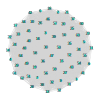

In [9]:
# Graph Checker
graph = get_HN_graph(parameters["images"],1.0)

elabels = [weights(graph)[e.src, e.dst] for e in edges(graph)]

# Plot with edge labels
 gplot(graph, 
      nodelabel=1:nv(graph))#, 
      #edgelabel=round.(elabels, digits=2),)

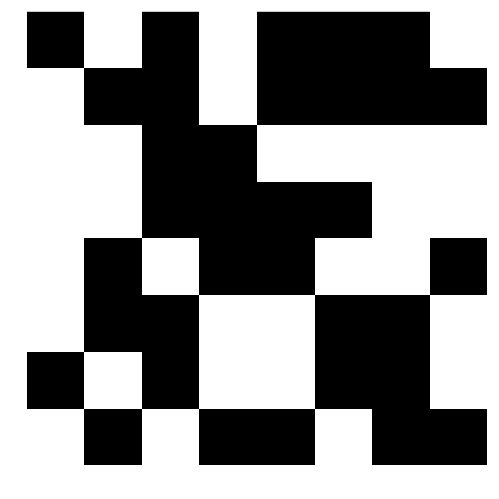

In [21]:
#Running
parameters["initial_stimuli"] = get_random_stimuli(parameters, 4)
pinned::Vector{Tuple{Int64, Int8}} = []
    state::Dice.Hybrid = Dice.get_random_hybrid(64, 2.0)
    #println(reshape(state[1],size(parameters["images"][1],1),size(parameters["images"][1],1)))
    for stim in parameters["initial_stimuli"]
        # Every n entries is a column, thus taking # of columns and subtracting 1 brings you to where the column begins
        # Adding 1 will bring you to the first entry in the column and so on for +k
        pos = (stim[2]-1) * size(parameters["images"][1],1) + stim[1]
        state[1][pos] = stim[3]
        push!(pinned, (pos, stim[3]))
    end
binary_image_visualizer(reshape(state[1],8,8),500,"image_init_t1",k= true,d= true)

In [33]:
#Running
parameters["initial_stimuli"] = get_random_stimuli(parameters, 1)
@show parameters["initial_stimuli"]
a = show_available_solutions(parameters,false)
println(length(a))
res = HN_Solver_Traj(parameters, true)
save_trajectories(res[2], "8by8","len6_t5_no2")
p = size(parameters["images"][1],1)
l = sol_finder(res[1], parameters)


println("showing min states")
graph = get_HN_graph(parameters["images"],1.0)
r = iterative_rotater_state(res[1], parameters)
s = []
c_now = 999
for i in r
    c_i = cut(graph, i)
    if c_i < c_now
        c_now = c_i
    end
end

for i in r
    c = cut(graph, i)
    if c == c_now
        push!(s,i)
    end
end
for i in s 
    pretty_table(reshape(i[1],8,8))
end

parameters["initial_stimuli"] = Any[(2, 5, 1)]
2
┌────────┬────────┬────────┬────────┬────────┬────────┬────────┬────────┐
│ Col. 1 │ Col. 2 │ Col. 3 │ Col. 4 │ Col. 5 │ Col. 6 │ Col. 7 │ Col. 8 │
├────────┼────────┼────────┼────────┼────────┼────────┼────────┼────────┤
│      1 │      1 │     -1 │     -1 │     -1 │     -1 │      1 │      1 │
│     -1 │     -1 │      1 │      1 │      1 │      1 │     -1 │     -1 │
│      1 │      1 │     -1 │     -1 │     -1 │     -1 │      1 │      1 │
│     -1 │     -1 │      1 │      1 │      1 │      1 │     -1 │     -1 │
│     -1 │     -1 │      1 │      1 │      1 │      1 │     -1 │     -1 │
│      1 │      1 │     -1 │     -1 │     -1 │     -1 │      1 │      1 │
│     -1 │     -1 │      1 │      1 │      1 │      1 │     -1 │     -1 │
│      1 │      1 │     -1 │     -1 │     -1 │     -1 │      1 │      1 │
└────────┴────────┴────────┴────────┴────────┴────────┴────────┴────────┘
File 8by8_1_len6_t5_no2.dat is generated
FOUND
┌────────┬──────

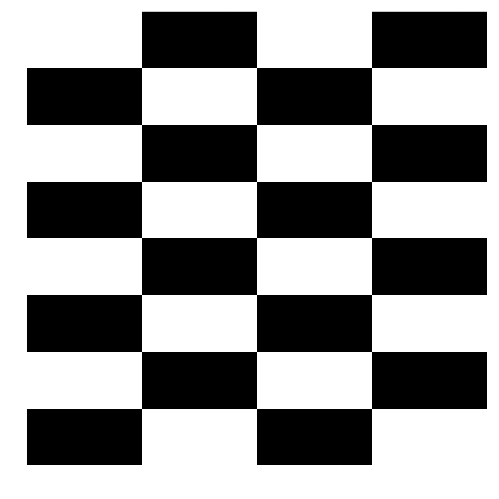

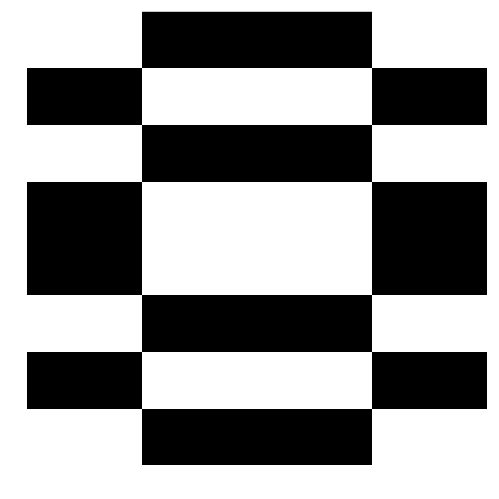

In [34]:
z = 0
for i in l
    z +=1
    binary_image_visualizer(reshape(i[1],8,8),500,"image_final_$(z)_t1",k= true,d= true)
end